In [1]:
%load_ext  autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('..')

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import ast

from trickster.search import a_star_search, ida_star_search
from trickster.expansion import *

from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import SVC
from scipy.spatial import distance
from tqdm import tqdm_notebook, tqdm
from matplotlib import pyplot as plt

from defaultcontext import with_default_context
from profiled import Profiler, profiled

SEED = 2018
np.random.seed(SEED)

## Load data

We assume the target linear model will work on one-hot discretized features. This is a common practice, since a linear model can only capture linear relationship between response and a continuous feature. If the continuous feature, however, is quantized, the relationship captured can be non-linear.

Therefore, we discretize and one-hot encode all features. We quantize the continuous features, like credit amount, age, etc., into 5 bins.

In [4]:
# Define helper functions.

def transform_collection(X_k):
    X_k = X_k.apply(lambda x: x.replace(';', ','))
    X_k = X_k.apply(ast.literal_eval)
    
    # Get the value of the maximum element in X_k.
    arg_max = np.max([item for sublist in X_k.values.tolist() for item in sublist])
    
    N = X_k.shape[0]
    X_k_transformed = np.zeros((N, arg_max+1), dtype='intc')
        
    for i in range(N):
        for item in X_k[i]:
            X_k_transformed[i, item] = 1

    return X_k_transformed

In [5]:
data_folder = 'data/twitter_bots/'

# Load data for humans.
df1 = pd.read_csv(data_folder + 'humans.1k.csv')
df1 = df1.drop('screen_name', axis=1) # remove screen_name column
df1 = df1.assign(is_bot=0)

# Load data for bots.
df2 = pd.read_csv(data_folder + 'bots.1k.csv')
df2 = df2.drop('screen_name', axis=1) # remove screen_name column
df2 = df2.assign(is_bot=1)

# Concatenate dataframes.
df = df1.append(df2, ignore_index=True)

# Perform feature quantization.
bins = 5
features = [
    'user_tweeted',
    'user_retweeted',
    'user_favourited',
    'user_replied',
    'likes_per_tweet',
    'retweets_per_tweet',
    'lists_per_user',
    'follower_friend_ratio',
    'tweet_frequency',
    'favourite_tweet_ratio',
    'age_of_account_in_days',
    'sources_count',
    'urls_count',
    'cdn_content_in_kb'
]

for feat in features:

    # Drop feature if there is only 1 distinct value.
    uniq_len = np.unique(df.loc[:, feat]).size
    if uniq_len == 1:
        df = df.drop(feat, axis=1)
        continue

    series = df.loc[:, feat]
    df.loc[:, feat] = pd.qcut(series, bins, duplicates='drop')
    
# Encode 'source_identity' field by setting '1's if source is present.
transformed = transform_collection(df.loc[:, 'source_identity'])
df = df.drop('source_identity', axis=1)

df['source_identity_other'] = transformed[:, 0]
df['source_identity_browser'] = transformed[:, 1]
df['source_identity_mobile'] = transformed[:, 2]
df['source_identity_osn'] = transformed[:, 3]
df['source_identity_automation'] = transformed[:, 4]
df['source_identity_marketing'] = transformed[:, 5]

# Perform one-hot encoding
df = pd.get_dummies(df)

# Separate features from targets
df_X = df.iloc[:, 1:]
df_y = df.iloc[:, 0]

print('Examples are represented as {}-dimensional vectors.'.format(df_X.shape[1]))

Examples are represented as 57-dimensional vectors.


In [6]:
# Convert to numpy
X = df_X.values.astype('intc')
y = df_y.values.astype('intc')
print('Shape of X: {}. Shape of y: {}.'.format(X.shape, y.shape))

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=SEED)
print('Number of training points: {}. Number of test points: {}.'.format(X_train.shape[0], X_test.shape[0]))

Shape of X: (1289, 57). Shape of y: (1289,).
Number of training points: 1160. Number of test points: 129.


## Fit the target model

Now we fit the target logistic regression model.

In [7]:
# Fit logistic regression and perform CV
from sklearn.metrics import make_scorer, accuracy_score, roc_auc_score, roc_curve, f1_score

Cs = np.arange(0.1, 2, 0.025)
class_weight = None # balanced or None
scoring = 'f1' # accuracy, f1 or roc_auc

clf = LogisticRegressionCV(
    Cs=Cs, 
    cv=5, 
    n_jobs=-1, 
    penalty='l2',
    scoring=scoring,
    class_weight=class_weight,
    random_state=SEED
)
clf.fit(X_train, y_train)

# Get best score and C value
mean_scores = np.mean(clf.scores_[1], axis=0)
best_idx = np.argmax(mean_scores)
best_score = mean_scores[best_idx]
best_C = clf.Cs_[best_idx]

constant_acc = 1 - sum(y_train) / len(y_train)
print('Training score for a constant model f(x) = 0 is: {:.2f}%.'.format(constant_acc*100))
print('Training accuracy is: {:.2f}%. Best C is: {:.4f}. Class weight: {}. Scoring: {}.'
      .format(clf.score(X_train, y_train)*100, best_C, class_weight, scoring))

# Training score for a constant model f(x) = 0 is: 61.38%.
# Training accuracy is: 88.02%. Best C is: 1.1750. Class weight: None. Scoring: f1.

Training score for a constant model f(x) = 0 is: 61.38%.
Training accuracy is: 88.02%. Best C is: 1.1750. Class weight: None. Scoring: f1.


In [8]:
constant_acc = 1 - sum(y_test) / len(y_test)
print('Test score for a constant model f(x) = 0 is: {:.2f}%.'.format(constant_acc*100))
print('Test accuracy is: {:.2f}%.'.format(clf.score(X_test, y_test)*100))

# Test score for a constant model f(x) = 0 is: 61.24%.
# Test accuracy is: 90.70%.

Test score for a constant model f(x) = 0 is: 61.24%.
Test accuracy is: 90.70%.


## Perform adversarial examples search

Context-local counter we'll use for counting expanded graph nodes.

In [51]:
class CounterLimitExceeded(Exception):
    pass

@with_default_context(use_empty_init=True)
class Counter:
    
    limit = 5000
    
    def __init__(self):
        self.cnt = 0
        
    def increment(self):
        if Counter.limit is not None and self.cnt > Counter.limit:
            raise CounterLimitExceeded('>> Expansion counter limit {} reached.'.format(Counter.limit))
        self.cnt += 1
        
    def set_count(self, count):
        self.cnt = count
    
    def get_count(self):
        return self.cnt

Define transformable features and obtain their indexes in the feature vectors.

In [52]:
def index(xs, item):
    '''Can be used to get the index of the required substring within a string.'''
    idxs = [i for (i, x) in enumerate(xs) if item in x]
    return idxs

TRANSFORMABLE_FEATURES = [
    'user_tweeted',
    'user_retweeted',
    'user_favourited',
    'user_replied',
    'urls_count'
]

FEATURE_SET = []

for x in TRANSFORMABLE_FEATURES:
    FEATURE_SET.extend(index(df_X.columns, x))

Define expansions required for the expand_fn when searching for adversarial examples.

In [53]:
features = df_X.columns
EXPANSIONS = []

# Define expansion for user_tweeted feature.
idxs = index(features, 'user_tweeted')
EXPANSIONS.append((idxs, expand_quantized))

# Define expansion for user_retweeted feature.
idxs = index(features, 'user_retweeted')
EXPANSIONS.append((idxs, expand_quantized))

# Define expansion for user_favourited feature.
idxs = index(features, 'user_favourited')
EXPANSIONS.append((idxs, expand_quantized))

# Define expansion for user_replied feature.
idxs = index(features, 'user_replied')
EXPANSIONS.append((idxs, expand_quantized))

# Define expansion for urls_count feature.
idxs = index(features, 'urls_count')
EXPANSIONS.append((idxs, expand_quantized))

All the functions that need to be passed into the search, in the expected format.

In [76]:
@profiled
def find_adversarial(x, clf, search_fn, epsilon, expansions, target_confidence=0.5, 
                p_norm=1, q_norm=np.inf, **kwargs):
    """Transform an example until it is classified with target confidence."""
    
    def expand_fn(x, expansions, p_norm=1):
        """Expand x and compute the costs.
        Returns a list of tuples (child, cost)
        """
        # Increment the counter of expanded nodes.
        counter = Counter.get_default()
        counter.increment()
        
        children = expand(x, expansions)
        costs = [np.linalg.norm(x - c, ord=p_norm) for c in children]
        
        return list(zip(children, costs))

    def goal_fn(x, clf, target_confidence=0.5):
        """Tell whether the example has reached the goal."""
        return clf.predict_proba([x])[0, 1] <= target_confidence

    def heuristic_fn(x, clf, epsilon, q_norm=np.inf):
        """Distance to the decision boundary of a logistic regression classifier.
        By default the distance is w.r.t. L1 norm. This means that the denominator
        has to be in terms of the Holder dual norm (`q_norm`), so L-inf. I know,
        this interface is horrible.
        NOTE: The value has to be zero if the example is already on the target side
        of the boundary.
        """
        score = clf.decision_function([x])[0]
        if score <= 0:
            return 0.0
        h = np.abs(score) / np.linalg.norm(clf.coef_[0, list(FEATURE_SET)], ord=q_norm)
        
        return h * epsilon

    def hash_fn(x):
        """Hash function for examples."""
        return hash(x.tostring())

    if clf.predict_proba([x])[0, 1] <= target_confidence:
        raise Exception('Initial example is already classified as bening.')
        
    heuristic_fn = kwargs.get('heuristic_fn', heuristic_fn)

    return search_fn(
        start_node=x,
        expand_fn=lambda x: expand_fn(x, expansions, p_norm=p_norm),
        goal_fn=lambda x: goal_fn(x, clf, target_confidence),
        heuristic_fn=lambda x: heuristic_fn(x, clf, epsilon, q_norm=q_norm),
        hash_fn=hash_fn
    )

Main function that performs adversarial example search.

In [13]:
def find_adv_examples(X, search_fn, columns, epsilon=1, target_confidence=0.5):
    """Find adversarial examples for a whole dataset"""
    
    # Dataframe for storing the results.
    results = pd.DataFrame(
        columns=['index', 'found', 'expansions', 'x', 'init_confidence', 
                 'x_adv', 'adv_confidence', 'real_cost', 'path_cost', 
                 'nodes_expanded', 'runtime']
    )
    
    # Indices of examples classified as bots.
    idxs, = np.where(clf.predict_proba(X)[:, 1] > target_confidence)
    
    for i, idx in enumerate(tqdm_notebook(idxs)):
        x = X[idx]
        
        # Instantiate a counter for expanded nodes, and a profiler.
        expanded_counter = Counter()
        per_example_profiler = Profiler()
        
        p_norm = 1
        q_norm = np.inf
        
        with expanded_counter.as_default(), per_example_profiler.as_default():
            try:
                x_adv, path_cost = find_adversarial(
                    x, 
                    clf, 
                    search_fn=search_fn,
                    epsilon=epsilon,
                    expansions=EXPANSIONS,
                    target_confidence=target_confidence,
                    p_norm=p_norm,
                    q_norm=q_norm,
                )
            except CounterLimitExceeded as e:
                print('>> WARN! {}'.format(e))
                continue

        nodes_expanded = expanded_counter.count()
        runtime = per_example_profiler.compute_stats()['find_adversarial']['tot']
        init_confidence = clf.predict_proba([x])[0, 1]
        
        # Record performed expansions and transformed features.
        expansions = [(x, y, z.__name__) for (x, (y, z)) in zip(TRANSFORMABLE_FEATURES, EXPANSIONS)]
        
        # If an adversarial example was not found, only record index, runtime, and 
        # the number of expanded nodes.        
        if x_adv is None:
            results.loc[i] = [idx, False, expansions, x, init_confidence, 
                              None, None, None, None, 
                              nodes_expanded, runtime]
        else:
            adv_confidence = clf.predict_proba([x_adv])[0, 1]
            real_cost = np.linalg.norm(x - x_adv, ord=p_norm)            
            results.loc[i] = [idx, True, expansions, x, init_confidence, 
                              x_adv, adv_confidence, real_cost, path_cost, 
                              nodes_expanded, runtime]

    return results

## Run the experiments

In [ ]:
results = find_adv_examples(
    X, 
    a_star_search, 
    columns=df_X.columns, 
    epsilon=1, 
    target_confidence=0.5
)

Visualise changes that are required to transform initial example into an adversarial one.

In [ ]:
def get_changes(x, x_adv, columns):
    init = np.where((x != x_adv) & (x == 1))[0]
    diff = np.where((x != x_adv) & (x_adv == 1))[0]
    changes = ['{} -> {}'.format(x, y) for (x, y) in zip(columns[init], columns[diff])]
    return changes

for idx, row in results.iterrows():
    if row['x_adv'] is None:
        continue
    changes = get_changes(row['x'], row['x_adv'], df_X.columns)
    idx = row['index']
    print('Adversarial example for sample at index {} was created with the following change(s):\n{}.\n'
          .format(idx, ',\n'.join(changes))
    )

Compare A\* search to IDA\* search to BFS.

In [181]:
def get_expanded_nodes_stats(X, target_confidence=0.5, p_norm=1, q_norm=np.inf):

    # Indices of examples classified as bots.
    idxs, = np.where(clf.predict_proba(X)[:, 1] > target_confidence)
    counts = []

    for i, idx in enumerate(tqdm_notebook(idxs)):
        
        x = X[idx]
        
        with Counter().as_default() as cnt_astar:
            try: 
                x_adv_1, _ = find_adversarial(x, clf, search_fn=a_star_search, epsilon=1, expansions=EXPANSIONS, 
                    target_confidence=target_confidence, p_norm=p_norm, q_norm=q_norm)       
            except CounterLimitExceeded:
                cnt_astar = Counter()
                cnt_astar.set_count(Counter.limit)
            
        with Counter().as_default() as cnt_bfs:
            try:
                heuristic_fn = lambda x, clf, epsilon, q_norm: 0 
                x_adv_2, _ = find_adversarial(x, clf, search_fn=a_star_search, epsilon=1, expansions=EXPANSIONS, 
                    target_confidence=target_confidence, p_norm=p_norm, q_norm=q_norm, heuristic_fn=heuristic_fn)       
            except CounterLimitExceeded:
                cnt_bfs = Counter()
                cnt_bfs.set_count(Counter.limit)
                
        if x_adv_1 is None and x_adv_2 is None:
            continue
        
        counts.append([cnt_astar.get_count(), cnt_bfs.get_count()])
        
    return pd.DataFrame(counts, columns=['A*', 'BFS'])

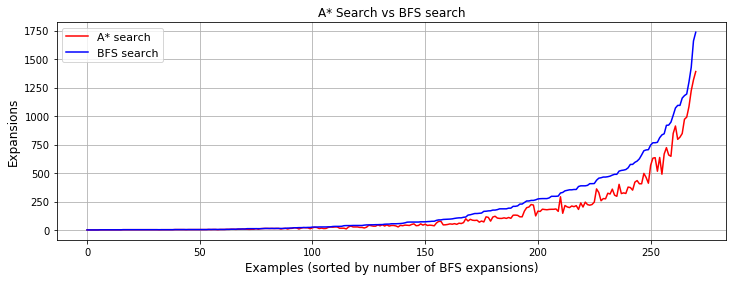

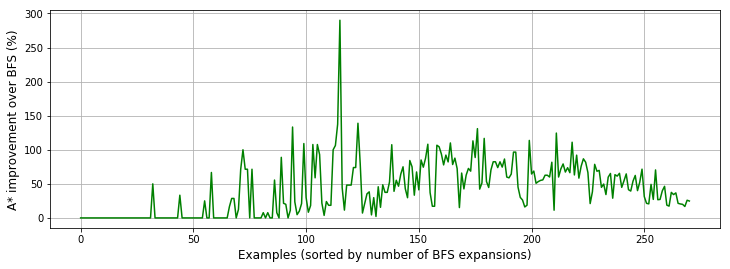

In [183]:
search_fns_stats = get_expanded_nodes_stats(X, target_confidence=0.5, p_norm=1, q_norm=np.inf)

# Obtain indexes that would sort the BFS expansions array.
idxs = np.argsort(search_fns_stats['BFS'].values)

# Display the "A* search vs BFS search" plot.
plt.figure(figsize=(12,4))
plt.title('A* Search vs BFS search')
plt.plot(search_fns_stats['A*'].values[idxs], color='red', label='A* search')
plt.plot(search_fns_stats['BFS'].values[idxs], color='blue', label='BFS search')
plt.grid(True)
plt.xlabel('Examples (sorted by number of BFS expansions)', fontsize=12)
plt.ylabel('Expansions', fontsize=12)
# plt.xticks(np.arange(0, len(search_fns_stats['A*'].values), 50))
# plt.yticks(np.arange(0, max(search_fns_stats['A*'].values), 500))
plt.legend(loc='best', fontsize=11)
plt.show()

# Display the "A* over BFS search improvement" plot.
improvement = (search_fns_stats['BFS'].values[idxs] - search_fns_stats['A*'].values[idxs])
improvement = (improvement / search_fns_stats['A*'].values[idxs]) * 100

plt.figure(figsize=(12,4))
plt.plot(improvement, color='green')
plt.grid(True)
# plt.xticks(np.arange(0, len(search_fns_stats['A*'].values), 50))
plt.xlabel('Examples (sorted by number of BFS expansions)', fontsize=12)
plt.ylabel('A* improvement over BFS (%)', fontsize=12)
plt.show()

Fix several target confidence levels.

In [ ]:
confidence_levels = np.linspace(0.50, 0.95, 10)
confidence_levels

Find adversarial examples for the whole dataset using different transformation graphs

In [ ]:
results_graph_1 = []
for level in tqdm_notebook(confidence_levels):
    results_graph_1.append(find_adv_examples(X, level))

In [ ]:
results_graph_2 = []
for level in tqdm_notebook(confidence_levels):
    results_graph_2.append(
        find_adv_examples(X, level, graph='increase_amount'))

In [ ]:
results_graph_3 = []
for level in tqdm_notebook(confidence_levels):
    results_graph_3.append(
        find_adv_examples(X, level, graph='increase_amount_and_duration'))

## Sanity check for the optimality

This part was used for debugging. It checks the costs of the found adversarial examples for all three graphs. Since the second graph is a subgraph of the first, and the third is a subgraph of the second ($G_3 \subset G_2 \subset G_1$), the path cost of the adversarial examples has to follow $C(x, x^*_{G_3}) \geq C(x, x^*_{G_2}) \geq C(x, x^*_{G_1})$.

In [ ]:
def example_diff(a, b):
    different_indices = np.where(a != b)
    return pd.DataFrame(
        [a[different_indices], b[different_indices]],
        columns=df_X.columns[different_indices],
    )

from IPython.display import display

In [ ]:
for result_graph_1, result_graph_2, result_graph_3 in zip(
        results_graph_1, results_graph_2, results_graph_3):

    for i, x in enumerate(X):
        a = result_graph_1['path_cost'][result_graph_1['index'] == i].values
        b = result_graph_2['path_cost'][result_graph_2['index'] == i].values
        c = result_graph_3['path_cost'][result_graph_3['index'] == i].values

        try:
            if len(a) > 0 and len(b) > 0 and not pd.isna(a) and not pd.isna(b):
                assert a[0] <= b[0]
            if len(b) > 0 and len(c) > 0 and not pd.isna(b) and not pd.isna(c):
                assert b[0] <= c[0]
            if len(a) > 0 and len(c) > 0 and not pd.isna(a) and not pd.isna(c):
                assert a[0] <= c[0]
        
        # Output information about violating examples.
        except AssertionError:
            print('Assumption violated at index', i)
            print('Real costs:', a, b, c)
            
            path_a = result_graph_1['path_cost'][result_graph_1['index'] == i].values
            path_b = result_graph_2['path_cost'][result_graph_2['index'] == i].values
            path_c = result_graph_3['path_cost'][result_graph_3['index'] == i].values
            print('Path costs:', path_a, path_b, path_c)
            
            conf_a = result_graph_1['confidence'][result_graph_1['index'] == i].values[0]
            conf_b = result_graph_2['confidence'][result_graph_2['index'] == i].values[0]
            conf_c = result_graph_3['confidence'][result_graph_3['index'] == i].values[0]
            print('Confidences:', conf_a, conf_b, conf_c)
            
            x_adv_a = result_graph_1['x_adv'][result_graph_1['index'] == i].values[0]
            x_adv_b = result_graph_2['x_adv'][result_graph_2['index'] == i].values[0]
            x_adv_c = result_graph_3['x_adv'][result_graph_3['index'] == i].values[0]
            
            if len(x_adv_a) > 0:
                display(example_diff(X[i], x_adv_a))
            if len(x_adv_b) > 0:
                display(example_diff(X[i], x_adv_b))
            if len(x_adv_c) > 0:
                display(example_diff(X[i], x_adv_c))

            continue

### Plots

Success rates for crafting adversarial examples, and average confidence of these.

In [ ]:
def plot_confidence(results):
    success_prop = [result['found'].mean() for result in results]
    avg_confidence = [result['confidence'].mean() for result in results]
    
    fig, ax = plt.subplots()
    ax.set_xticks(confidence_levels)
    ax.plot(confidence_levels, success_prop,
            label='Success proportion')
    ax.plot(confidence_levels, avg_confidence,
            label='Avg confidence of adversarial examples')
    ax.plot(confidence_levels, confidence_levels,
            linestyle='dashed', color='gray', label='Baseline confidence')
    ax.set_xlabel('Target confidence')
    ax.set_ylabel('')
    plt.legend()
    plt.show()

Graph 1 (changing "amount", "duration", and "purpose" in any direction)

In [ ]:
plot_confidence(results_graph_1)

Graph 2 (changing "duration" in any direction, and "purpose", and only increasing "amount")

In [ ]:
plot_confidence(results_graph_2)

Graph 3 (changing "purpose" in any direction, and only increasing "amount" and "duration")

In [ ]:
plot_confidence(results_graph_3)

Number of expanded nodes for graph 1 (strongly correlated with runtime)

In [ ]:
avg_expanded = pd.Series(
    [np.mean(result['nodes_expanded'][result['found']])
     for result in results_graph_1])
sigma_expanded = pd.Series(
    [np.std(result['nodes_expanded'][result['found']])
     for result in results_graph_1])

avg_runtime = pd.Series(
    [np.mean(result['runtime'][result['found']])
     for result in results_graph_1])

fig, ax = plt.subplots()
avg_expanded.plot(label='Number of expanded nodes', ax=ax)
ax.fill_between(range(len(confidence_levels)),
                avg_expanded - 2 * sigma_expanded,
                avg_expanded + 2 * sigma_expanded, alpha=.2)
ax.set_xticks(range(len(confidence_levels)))
ax.set_xticklabels(['%2.2f' % level for level in confidence_levels])
ax.set_xlim(0, len(confidence_levels) - 1)
ax.set_xlabel('Target confidence')
ax.set_ylabel('Number of expanded nodes')

# avg_runtime.plot(secondary_y=True, label='Avg runtime')
plt.show()